# Fig. AR Climatology

Plot domain and variables used for EOF analysis

In [2]:
# Import Python modules
import os, sys
import numpy as np
import pandas as  pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import seaborn as sns
import cmocean.cm as cmo
import cmocean
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from pathlib import Path
from IPython.display import Image, display
from scipy.ndimage import gaussian_filter    # smoothing contour lines

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, make_cmap
from ar_funcs import get_ar_days, get_topo_mask

### Set up paths

In [3]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [4]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


In [5]:
# label strings

ivt_units = 'kg m$^{-1}$ s$^{-1}$'

## ERA5 Data

In [6]:
# Select lat/lon grid
bnds = [45, 100, 0, 50]
lonmin, lonmax, latmin, latmax = bnds

### ERA5 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open IVT non-anomaly data
filepath_pattern = path_to_data + 'ERA5/ivt/daily/out.era5*.nc'
f1 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(f1.nbytes / 1e9))

# Create new dataset to rename lat lon
era = xr.Dataset({'ivte': (['time', 'lat', 'lon'], f1['p71.162'].values),
                  'ivtn': (['time', 'lat', 'lon'], f1['p72.162'].values)},
                  coords={'time': (['time'], f1.time.values),
                          'lat': (['lat'], f1.latitude.values),
                          'lon': (['lon'], f1.longitude.values)})

# Mean IVT of all days
era_clim = era.groupby('time.season').mean(dim='time')
era_clim

ds size in GB 1.34



<xarray.Dataset>
Dimensions:  (lat: 101, lon: 111, season: 4)
Coordinates:
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 45.0 45.5 46.0 46.5 47.0 ... 98.5 99.0 99.5 100.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    ivte     (season, lat, lon) float32 43.097324 43.18745 ... 55.26267 35.37363
    ivtn     (season, lat, lon) float32 19.397394 19.48686 ... -16.489422

## Calculate AR climatology

In [7]:
%%time
ar_filename = path_to_data + 'ar_catalog/globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
ar_ds = xr.open_dataset(ar_filename)
ar_ds = ar_ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))
ar_ds = ar_ds.shape.load()
# clat = ar_ds.clat
# clon = ar_ds.clon
# hlat = ar_ds.hlat
# hlon = ar_ds.hlon
# tlat = ar_ds.tlat
# tlon = ar_ds.tlon


# count number of AR time steps per season
count_DJF = len(ar_ds.groupby('time.season').groups['DJF'])
print(count_DJF)
count_MAM = len(ar_ds.groupby('time.season').groups['MAM'])
count_JJA = len(ar_ds.groupby('time.season').groups['JJA'])
count_SON = len(ar_ds.groupby('time.season').groups['SON'])

count_lst = [count_DJF, count_MAM, count_JJA, count_SON]

# count number of AR time steps per gridcell
ar_da = ar_ds.groupby('time.season').count(dim='time')

14676
CPU times: user 14.2 s, sys: 852 ms, total: 15.1 s
Wall time: 15.3 s


In [8]:
print(count_MAM)

15088


## Create figure

In [8]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# get topo mask for 1000 m line
regridlats = era.lat
regridlons = era.lon
regrid_topo = get_topo_mask(regridlats, regridlons)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


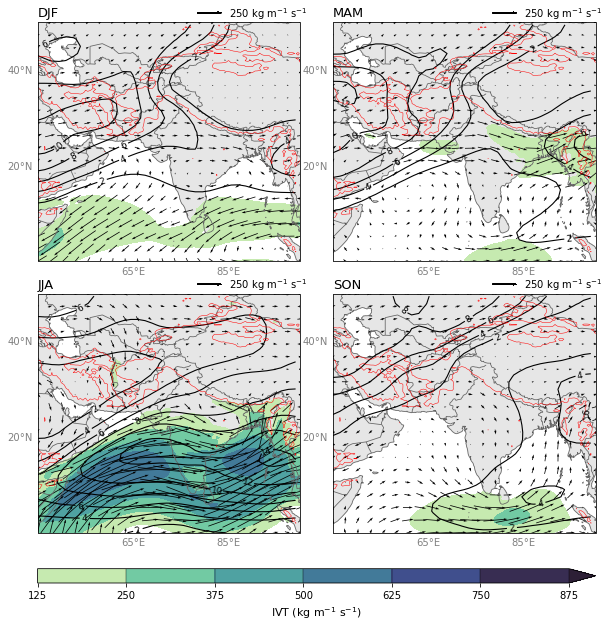

In [9]:
# Data for plotting
data = era_clim
lons = data.lon.values
lats = data.lat.values
count_lst = [count_DJF, count_MAM, count_JJA, count_SON]

# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')

# cmap setup
cmap = cmo.deep
clipcmap = cmocean.tools.crop_by_percent(cmap, 5, which='both', N=None)
cflevs = np.arange(125, 1000, 125)
ssn_lst = ['DJF', 'MAM', 'JJA', 'SON']

# Loop for drawing each plot
for k, (ax, ssn) in enumerate(zip(axgr, ssn_lst)):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled
    # Average Seasonal Total
    uvec = data.ivte.sel(season=ssn).values
    vvec = data.ivtn.sel(season=ssn).values
    ivt = np.sqrt(uvec**2 + vvec**2)
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                    levels=cflevs,cmap=clipcmap, extend='max')
    
    
    # Contour Lines
    # Percent Frequency
    ar_lats = ar_da.lat.values
    ar_lons = ar_da.lon.values
    ar_count = ar_da.sel(season=ssn).squeeze()
    contr = np.divide(ar_count.values, float(count_lst[k]))
    ar_smooth = gaussian_filter(contr*100, sigma=1.5)
    clevs = np.arange(2, 22, 2)
    cs = ax.contour(ar_lons, ar_lats, ar_smooth, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    kw_clabels = {'fontsize': 9, 'inline': True, 'inline_spacing': 8, 'fmt': '%d',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # IVT vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs,
                  color='black', regrid_shape=20, pivot='middle', 
                  angles='xy', scale_units='xy', scale=50, units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.04, 250, r'250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                   coordinates='axes', fontproperties={'size': 10.0})
    
    # Contour Lines (terrain)
    clevs=np.array([1000])
    cs = ax.contour(regridlons, regridlats, regrid_topo.bedrock, clevs, colors='red', linewidths=0.5,
                    linestyles='solid', transform=datacrs)
    
    # Subtitles
    ax.set_title(ssn_lst[k], loc='left', fontsize=13)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'ivt_clim_all_ssn' + '.png'
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()

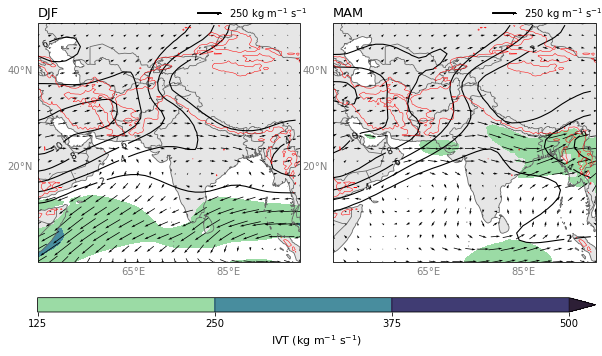

In [10]:
# Data for plotting
data = era_clim
lons = data.lon.values
lats = data.lat.values
count_lst = [count_DJF, count_MAM, count_JJA, count_SON]

# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')

# cmap setup
cmap = cmo.deep
clipcmap = cmocean.tools.crop_by_percent(cmap, 5, which='both', N=None)
cflevs = np.arange(125, 625, 125)
ssn_lst = ['DJF', 'MAM']

# Loop for drawing each plot
for k, (ax, ssn) in enumerate(zip(axgr, ssn_lst)):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled
    # Average Seasonal Total
    uvec = data.ivte.sel(season=ssn).values
    vvec = data.ivtn.sel(season=ssn).values
    ivt = np.sqrt(uvec**2 + vvec**2)
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                    levels=cflevs,cmap=clipcmap, extend='max')
    
    
    # Contour Lines
    # Percent Frequency
    ar_lats = ar_da.lat.values
    ar_lons = ar_da.lon.values
    ar_count = ar_da.sel(season=ssn).squeeze()
    contr = np.divide(ar_count.values, float(count_lst[k]))
    ar_smooth = gaussian_filter(contr*100, sigma=1.5)
    clevs = np.arange(2, 22, 2)
    cs = ax.contour(ar_lons, ar_lats, ar_smooth, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    kw_clabels = {'fontsize': 9, 'inline': True, 'inline_spacing': 8, 'fmt': '%d',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # IVT vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs,
                  color='black', regrid_shape=20, pivot='middle', 
                  angles='xy', scale_units='xy', scale=50, units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.04, 250, r'250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                   coordinates='axes', fontproperties={'size': 10.0})
    
    # Contour Lines (terrain)
    clevs=np.array([1000])
    cs = ax.contour(regridlons, regridlats, regrid_topo.bedrock, clevs, colors='red', linewidths=0.5,
                    linestyles='solid', transform=datacrs)
    
    # Subtitles
    ax.set_title(ssn_lst[k], loc='left', fontsize=13)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'ivt_clim_djf_mam' + '.png'
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()